<a href="https://colab.research.google.com/github/sizhky/AutoTrain/blob/segmentation/nbs/2_segmentation_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Data and Libraries

In [1]:
%%capture
try:
    from icevision.all import *
except:
    !pip install -U torch-snippets typer imgaug
    !wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
    !bash install_colab.sh

In [2]:
# Setup Data
# %%capture
%load_ext autoreload
%autoreload 2

from torch_snippets import *

# If running locally from AutoTrain/nbs
if not os.path.exists('/content') and P().resolve().stem != 'AutoTrain':
    %cd ..

if os.path.exists('/content') and not os.path.exists('/content/AutoTrain'):
    !git clone https://github.com/sizhky/AutoTrain

if not P().resolve().stem == 'AutoTrain':
    %cd AutoTrain

!git pull origin V1
!git checkout V1

if not os.path.exists('balloon.zip'):
    !wget --quiet https://www.dropbox.com/s/tur7gzmuuzb2vzf/balloon.zip -O balloon.zip
if not os.path.exists('balloon/data/'):
    makedir('balloon')
    unzip_file('balloon.zip', 'balloon/data/')

/mnt/d04d289c-d0a7-4fd4-b883-ff227b3a8695/githubs/AutoTrain
From https://github.com/sizhky/AutoTrain
 * branch            V1         -> FETCH_HEAD
Already up to date.
Already on 'V1'
Your branch is up to date with 'origin/V1'.


## Verify Config

In [13]:
!cat config.ini

[project]
owner: sizhky
name: baloons
location: ${project.name}
model_directory: ${project.location}/models
type: segmentation

[architecture]
model_type: torchvision.mask_rcnn
backbone: resnet34_fpn
pretrained: True
size: 384
[architecture.extra_args]

[training]
; absolute path, or path relative to AutoTrain folder
dir: balloon/data/balloon
; folder should be exported from label studio, 
; in COCO format for segmentation, i.e., 
; it should have one images dir and one results.json file
images_dir: ${training.dir}/images
annotations_file: ${training.dir}/result.json
train_ratio: 0.8

[training.preprocess]
@augmentations: get_train_transforms
size: ${architecture.size}
presize: 512

[training.scheme]
epochs: 20
lr: 1e-4
freeze_epochs: 1
output_path: ${project.model_directory}/model.pt

[testing]
[testing.preprocess]
@augmentations: get_val_transforms
size: ${architecture.size}
presize: 512


In [9]:
os.environ['CONFIG'] = 'config_segmentation.ini'
!python auto_train_segmentation/train.py find-best-learning-rate

INFO     - 
CLASSES INFERRED FROM balloon/data/balloon/result.json: <ClassMap: {'background': 0, 'balloon': 1}> | __main__:<module>:34
100%|████████████████████████████████████████| 255/255 [00:00<00:00, 518.04it/s]
INFO     - Autofixing records | icevision.parsers.parser:parse:136
100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 5991.20it/s]
INFO     - LR Plot is saved at baloons/find_lr_plot.png | __main__:find_best_learning_rate:80
INFO     - Suggested LRs: 0.0006309573538601399 and 1.4454397387453355e-05 | __main__:find_best_learning_rate:81


In [33]:
os.environ['CONFIG'] = 'config_segmentation.ini'
!python auto_train_segmentation/train.py train-model --lr 4.365158267319202e-05

INFO     - 
CLASSES INFERRED FROM balloon/data/balloon/result.json: <ClassMap: {'background': 0, 'balloon': 1}> | __main__:<module>:34
100%|███████████████████████████████████████| 255/255 [00:00<00:00, 2244.67it/s]
INFO     - Autofixing records | icevision.parsers.parser:parse:136
100%|████████████████████████████████████████| 13/13 [00:00<00:00, 13218.41it/s]
INFO     - Loaded weights from baloons/models/model.pt to given model | __main__:train_model:87
[0, 1.078104853630066, 0.80428147315979, 0.15314963017105154, '00:07']
[0, 1.056432843208313, 0.809590756893158, 0.16396020767439654, '00:08']
[1, 1.0458848476409912, 0.8110312819480896, 0.1521259160799801, '00:08']
[2, 1.047467589378357, 0.8237537741661072, 0.13200266981122477, '00:08']
[3, 1.0257574319839478, 0.817683219909668, 0.13218423967902862, '00:07']
[4, 1.028222680091858, 0.8430755138397217, 0.12064020289547524, '00:08']
[5, 1.0255986452102661, 0.8170281052589417, 0.13825889154935847, '00:07']
[6, 1.0311779975891113, 0.81270

---
## Validate

In [6]:
from torch_snippets import *
from icevision.all import *
from auto_train_object_detection.custom_functions import *
from torch_snippets.registry import registry, Config, AttrDict

os.environ['CONFIG'] = 'config_segmentation.ini'

config = Config().from_disk(os.environ['CONFIG'])
config = AttrDict(registry.resolve(config))

image_size = config.architecture.size
class_map = ClassMap(config.project.classes)

assert config.architecture.model_type.count('.', 1), "Architecture should look like <base>.<model>"
extra_args = config.architecture.extra_args
a, b = config.architecture.model_type.split('.')
model_type = getattr(getattr(models, a), b)
backbone = getattr(model_type.backbones, config.architecture.backbone)(config.architecture.pretrained)
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(class_map), **extra_args)

from torch_snippets import load_torch_model_weights_to, save_torch_model_weights_from, makedir
yolo_path = config.training.scheme.output_path
load_torch_model_weights_to(model, yolo_path)


In [7]:
folder = 'balloon/data/balloon/validation'
fpaths = []
image_extns = ['png','jpg','jpeg']
for extn in image_extns:
    fpaths += P(folder).Glob(f'*.{extn}')
imgs = [read(f, 1) for f in fpaths[:4]]
logger.info(f'Found {len(imgs)} images')

infer_tfms = tfms.A.Adapter([
    *tfms.A.resize_and_pad(size=512),
    tfms.A.Normalize()
])

infer_ds = Dataset.from_images(imgs, infer_tfms, class_map=class_map)
infer_dl = model_type.infer_dl(infer_ds, batch_size=1)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/4 [00:00<?, ?it/s]

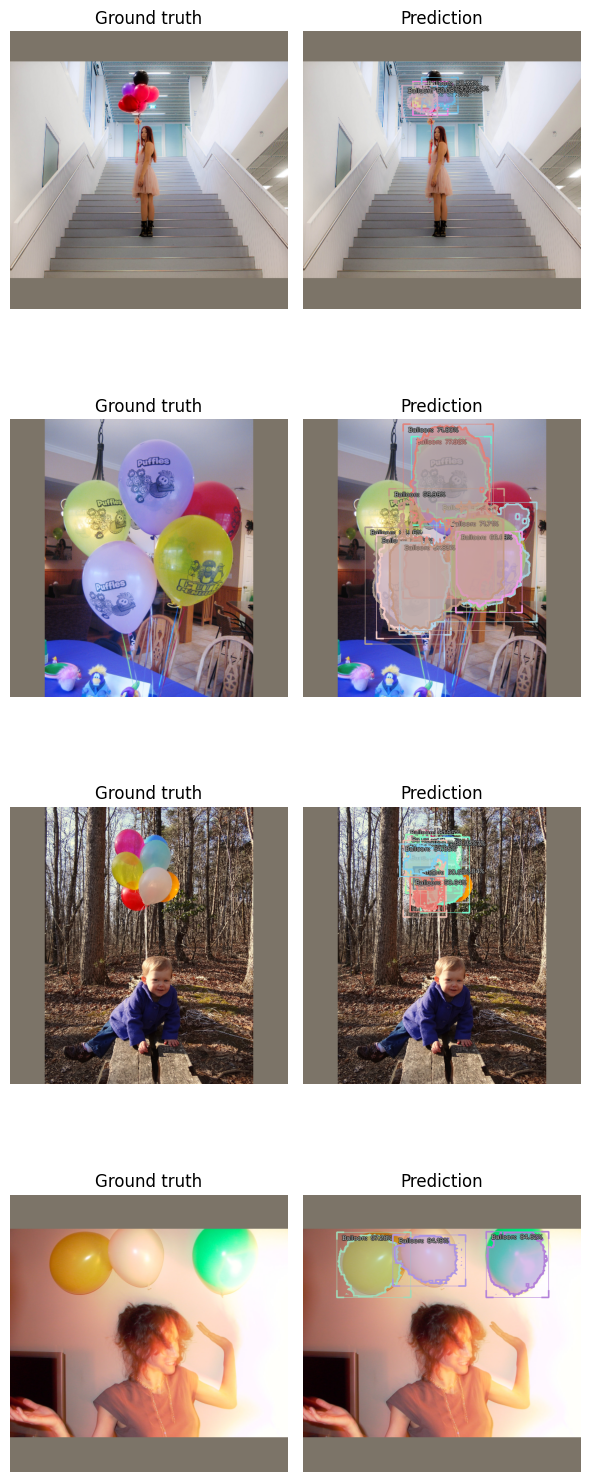

In [8]:
show_preds(preds=preds, ncols=3)